In [ ]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder

import tensorflow as tf
from keras import layers, Sequential
from keras.regularizers import l2

import matplotlib.pyplot as plt

from project.utils import DATA_FOLDER, SUBSET, load_tracks, load_handcrafted

In [2]:
tracks = load_tracks(DATA_FOLDER)
features = load_handcrafted(DATA_FOLDER)

In [5]:
subset = tracks['set', 'subset'] <= SUBSET

train = tracks["set", "split"] == "training"
val = tracks["set", "split"] == "validation"
test = tracks["set", "split"] == "test"

y_train = tracks.loc[subset & train, ("track", "genre_top")]
y_val = tracks.loc[subset & val, ("track", "genre_top")]
y_test = tracks.loc[subset & test, ("track", "genre_top")]

X_train = features.loc[subset & train]
X_val = features.loc[subset & val]
X_test = features.loc[subset & test]

In [8]:
# redefine typer for genres column
y_train = y_train.astype(
    pd.CategoricalDtype(
        categories=[
            "Electronic",
            "Experimental",
            "Folk",
            "Hip-Hop",
            "Instrumental",
            "International",
            "Pop",
            "Rock",
        ]
    )
)

In [9]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((6400, 518), (6400,), (800, 518), (800,), (800, 518), (800,))

In [10]:
counts = y_train.value_counts()
classes = list(y_train.unique())
n_classes = len(counts)
counts

Electronic       800
Experimental     800
Folk             800
Hip-Hop          800
Instrumental     800
International    800
Pop              800
Rock             800
Name: (track, genre_top), dtype: int64

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

lab_encoder = LabelEncoder()
lab_encoder.fit(y_train)

y_train = lab_encoder.transform(y_train)
y_val = lab_encoder.transform(y_val)
y_test = lab_encoder.transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train, 8)
y_val = tf.keras.utils.to_categorical(y_val, 8)
y_test = tf.keras.utils.to_categorical(y_test, 8)

In [19]:
tf.keras.backend.clear_session()

model = Sequential(
    [
        layers.Dense(
            512, input_shape=(518,), activation="relu", kernel_regularizer=l2(0.02)
        ),
        layers.Dense(256, activation="relu", kernel_regularizer=l2(0.02)),
        layers.Dense(n_classes, activation="softmax", kernel_regularizer=l2(0.02)),
    ]
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"],
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               265728    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 399,112
Trainable params: 399,112
Non-trainable params: 0
_________________________________________________________________


In [13]:
batch_size = 32

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
)

Epoch 1/200
200/200 [==============================] - 4s 11ms/step - loss: 16.9910 - accuracy: 0.4142 - val_loss: 14.7958 - val_accuracy: 0.4875
Epoch 2/200
200/200 [==============================] - 2s 10ms/step - loss: 12.9347 - accuracy: 0.5553 - val_loss: 11.4451 - val_accuracy: 0.4988
Epoch 3/200
200/200 [==============================] - 2s 11ms/step - loss: 9.8776 - accuracy: 0.6003 - val_loss: 8.8220 - val_accuracy: 0.5312
Epoch 4/200
200/200 [==============================] - 2s 11ms/step - loss: 7.5751 - accuracy: 0.6233 - val_loss: 6.8034 - val_accuracy: 0.5437
Epoch 5/200
200/200 [==============================] - 2s 10ms/step - loss: 5.8664 - accuracy: 0.6441 - val_loss: 5.3587 - val_accuracy: 0.5600
Epoch 6/200
200/200 [==============================] - 2s 10ms/step - loss: 4.6149 - accuracy: 0.6486 - val_loss: 4.3318 - val_accuracy: 0.5387
Epoch 7/200
200/200 [==============================] - 1s 7ms/step - loss: 3.7068 - accuracy: 0.6561 - val_loss: 3.6162 - val_accura

/tmp/ipykernel_3271/3007752394.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


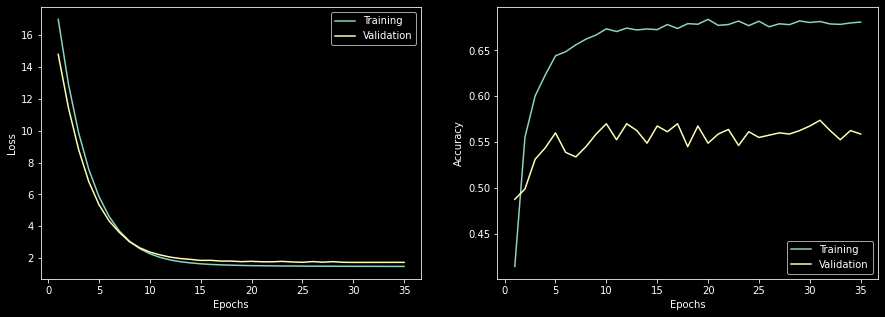

In [14]:
def plot_history(history):
    x_plot = list(range(1, len(history["loss"]) + 1))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.plot(x_plot, history["loss"])
    ax1.plot(x_plot, history["val_loss"])
    ax1.legend(["Training", "Validation"])

    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.plot(x_plot, history["accuracy"])
    ax2.plot(x_plot, history["val_accuracy"])
    ax2.legend(["Training", "Validation"], loc="lower right")

    fig.show()


plot_history(history.history)

In [15]:
loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)

25/25 [==============================] - 0s 4ms/step - loss: 1.9253 - accuracy: 0.4787


In [16]:
y_pred = model.predict(X_test, batch_size=batch_size)

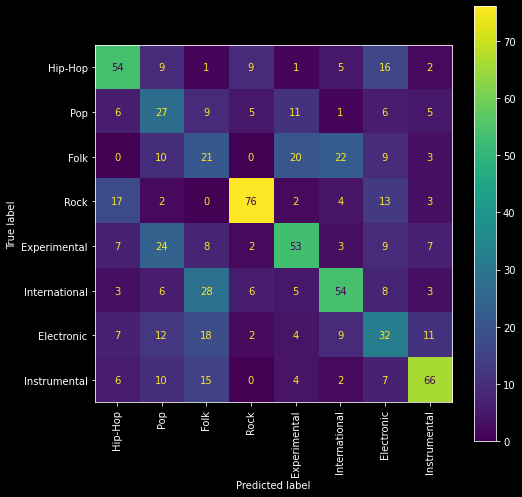

In [17]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    classification_report,
)

cm = confusion_matrix(np.argmax(y_pred, 1), np.argmax(y_test, 1))

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(ax=ax, xticks_rotation=90)

# Classical Classifiers

In [18]:
import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

models = [
    ("SVM", SVC()),
    ("KNN", KNeighborsClassifier()),
    ("RF", RandomForestClassifier()),
    ("GNB", GaussianNB()),
]

yy_train = np.argmax(y_train, 1)
yy_test = np.argmax(y_test, 1)

for name, model in models:
    print(name)
    start_time = time.perf_counter()
    model.fit(X_train, yy_train)
    y_pred = model.predict(X_test)
    elapsed = time.perf_counter() - start_time
    report = classification_report(y_pred=y_pred, y_true=yy_test)
    print(elapsed)
    print(report)

SVM
25.085211917999914
              precision    recall  f1-score   support

           0       0.58      0.60      0.59       100
           1       0.36      0.43      0.39       100
           2       0.25      0.25      0.25       100
           3       0.68      0.72      0.70       100
           4       0.41      0.38      0.39       100
           5       0.58      0.41      0.48       100
           6       0.42      0.41      0.41       100
           7       0.59      0.63      0.61       100

    accuracy                           0.48       800
   macro avg       0.48      0.48      0.48       800
weighted avg       0.48      0.48      0.48       800

KNN
0.9184361029999764
              precision    recall  f1-score   support

           0       0.42      0.33      0.37       100
           1       0.40      0.21      0.27       100
           2       0.20      0.31      0.25       100
           3       0.49      0.59      0.53       100
           4       0.29      0.1